Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
import pickle
import os.path
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
import time

## Folder dir for saving and loading files

In [2]:
model_folder = 'data/model/'
trajectory_folder = 'data/trajectory/'
optimal_trajectory_folder = 'data/optimal_trajectory/'

---
# 2 - Robot modelling

## Create joint variables and define their relations

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9 = new_sym('q:10')
# define paralelogram coordinate relation
# q3 = -q2 + q4
# q5 = -q4 + q2

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [5]:
# robot_def = RobotDef([(0,   -1, [1],    0, 0, 0, 0),
#                       (1,   0,  [2, 4], 0, 0, -0.21537, q1),
#                       (2,   1,  [3],    0, -sympy.pi/2, 0, q2+sympy.pi/2),
#                       (3,   2,  [],    0.279, 0, 0, q3+sympy.pi/2),
#                       (4,   1,  [5],    0, -sympy.pi/2, 0, q4+sympy.pi),
#                       (5,   4,  [],     0.1, 0, 0, q5-sympy.pi/2)],
#                      dh_convention='mdh',
#                      friction_type=['Coulomb', 'viscous', 'offset'])

name = 'psm'

if (name == 'mtm'):
    robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0,                  False, False, False),
                          (1,   0,  [2],    0,      0,              -0.21537,   q1,                 True,  False, True),
                          (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2,      True,  False, True),
                          (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2,  True,  True,  True)],
                         dh_convention='mdh',
                         friction_type=['Coulomb', 'viscous', 'offset'])

elif (name == 'psm'):
    robot_def = RobotDef([(0,   -1, [1],    0,      0,     0,          0,                     False, False, False),
                      (1,   0,  [2],   0,  sympy.pi/2,   0.5,   q1+sympy.pi/2,       True,  False, True),
                      (2,   1,  [3], 0.1, -sympy.pi/2,     0,   q2-sympy.pi/5,      True,  False, True),
                      (3,   2,  [4], 0.5,           0,     0,   -q2+sympy.pi/5+sympy.pi/2,    True,  False, True),
                      (4,   3,  [5],   1,           0,     0,    q2,                               True,  False, True),
                      (5,   4,  [6], 0.2, -sympy.pi/2,0.5+q3,    sympy.pi/2,        True,  False, True)],
                         dh_convention='mdh',
                         friction_type=['Coulomb', 'viscous', 'offset'])
    
elif( name == 'psm_long'):
    robot_def = RobotDef([(0,   -1, [1],    0,      0,     0,          0,                     False, False, False),
                      (1,   0,  [2],   0,  sympy.pi/2,   0.5,   q1+sympy.pi/2,       True,  False, True),
                      (2,   1,  [3], 0.1, -sympy.pi/2,     0,   q2-sympy.pi/5,      True,  False, True),
                      (3,   2,  [4], 0.5,           0,     0,   -q2+sympy.pi/5+sympy.pi/2,    True,  False, True),
                      (4,   3,  [5],   1,           0,     0,    q2,                               True,  False, True),
                      (5,   4,  [6], 0.2, -sympy.pi/2,0.5+q3,    sympy.pi/2,        True,  False, True),
                      (6,   5,  [7],   0,           0,   0.2,    -sympy.pi/2+q4,                True,  False, True),
                      (7,   6,[8,9], 0.5, -sympy.pi/2,     0,   -sympy.pi/2+q5,    False,  True, True),
                      (8,   7, [15], 0.3, -sympy.pi/2,     0,    -sympy.pi/2+q6-q7, False,  True, True),
                      (9,   7, [15], 0.3, -sympy.pi/2,     0,    -sympy.pi/2+q6+q7, False,  True, True),
                      (10,  2, [11],   0,           0,   0.5,    sympy.pi/5+sympy.pi/2,        False,  False, False),
                      (11, 10, [15],-0.5, +sympy.pi/2, 0.13*q3,    0, True,  False, True)],
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous', 'offset'])


In [454]:
# robot_def = RobotDef([(0,   -1, [1],    0, 0, 0, 0),
#                       (1,   0,  [2, 4], 0, 0, -0.21537, q1),
#                       (2,   1,  [3],    0, -sympy.pi/2, 0, q2+sympy.pi/2),
#                       (3,   2,  [],    0.279, 0, 0, q3+sympy.pi/2),
#                       (4,   1,  [5],    0, -sympy.pi/2, 0, q4+sympy.pi),
#                       (5,   4,  [],     0.1, 0, 0, q5-sympy.pi/2)],
#                      dh_convention='mdh',
#                      friction_type=['Coulomb', 'viscous', 'offset'])

robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0,                  False, False, False),
                      (1,   0,  [2],    0,      0,              -0.21537,   q1,                 True,  False, True),
                      (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2,      True,  False, True),
                      (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2,  True,  True,  True)],
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous', 'offset'])

In [ ]:
robot_def.Ia

In [ ]:
robot_def.std_params

In [457]:
robot_def.bary_params

## Create kinematics chain

In [497]:
% time geom = Geometry(robot_def)

CPU times: user 4.69 s, sys: 16.2 ms, total: 4.7 s
Wall time: 4.69 s


In [ ]:
geom.draw_geom()

NameError: name 'geom' is not defined

In [ ]:
geom = Geometry(robot_def)


KeyboardInterrupt: 

In [499]:
geom.T_0nc[1]

⎡                      l1x⋅cos(q₁)   l1y⋅sin(q₁)⎤
⎢cos(q₁)  -sin(q₁)  0  ─────────── - ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                      l1x⋅sin(q₁)   l1y⋅cos(q₁)⎥
⎢sin(q₁)  cos(q₁)   0  ─────────── + ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                            l1z                ⎥
⎢   0        0      1        ─── - 0.21537      ⎥
⎢                             m₁                ⎥
⎢                                               ⎥
⎣   0        0      0              1            ⎦

## Create dynamics

In [501]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating joint torques...
Adding frictions and motor rotor inertia...
Calculating gregressor...
Calculating M, C and G...
Calculating base parameter...


TypeError: can't convert expression to float

In [500]:
# import profile

# def dynamics_test():
#     global robot_def
#     global geom
#     dyn = Dynamics(robot_def, geom)
#     return dyn

# profile.run("dynamics_test()")

Calculating Lagrangian...
Calculating joint torques...
Adding frictions and motor rotor inertia...
Calculating gregressor...
Calculating M, C and G...
Calculating base parameter...
base parameter number: 22
Creating H_b function...
Finished creating robot dynamics
         528829316 function calls (506643398 primitive calls) in 1754.308 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    0.000    0.000 :0(__array__)
       72    0.000    0.000    0.000    0.000 :0(__contains__)
   165653    0.292    0.000    0.292    0.000 :0(__new__)
        2    0.000    0.000    0.000    0.000 :0(_getframe)
    67986    0.132    0.000    0.132    0.000 :0(_mpmath_create)
    75550    0.146    0.000    0.146    0.000 :0(_mpmath_normalize)
   482562    0.840    0.000    0.843    0.000 :0(abs)
    18681    0.072    0.000    0.096    0.000 :0(add)
445998/388383    3.082    0.000    8.188    0.000 :0(all)
32324/2824

       52    0.000    0.000    0.000    0.000 dynamics.py:22(<lambda>)
        1    0.000    0.000 1754.307 1754.307 dynamics.py:26(__init__)
        1    0.001    0.001 1741.144 1741.144 dynamics.py:44(_calc_dyn)
      270    0.002    0.000    0.002    0.000 euclidtools.py:1136(_dup_zz_gcd_interpolate)
     5817    0.071    0.000    0.625    0.000 euclidtools.py:1152(dup_zz_heu_gcd)
     1038    0.023    0.000    0.777    0.001 euclidtools.py:1258(_dmp_zz_gcd_interpolate)
16734/1296    0.155    0.000  979.918    0.756 euclidtools.py:1275(dmp_zz_heu_gcd)
      186    0.007    0.000    0.072    0.000 euclidtools.py:1382(dup_qq_heu_gcd)
  4013/12    0.022    0.000  551.936   45.995 euclidtools.py:1431(dmp_qq_heu_gcd)
     5593    0.040    0.000    0.679    0.000 euclidtools.py:1480(dup_inner_gcd)
19684/1265    0.150    0.000 1489.500    1.177 euclidtools.py:1531(_dmp_inner_gcd)
21274/1331    0.269    0.000 1495.607    1.124 euclidtools.py:1567(dmp_inner_gcd)
     3991    0.016    0.000  

       18    0.000    0.000    0.007    0.000 polytools.py:246(__hash__)
     1163    0.013    0.000 1033.269    0.888 polytools.py:3225(factor_list)
       18    0.000    0.000  561.952   31.220 polytools.py:3673(cancel)
       18    0.001    0.000    0.010    0.001 polytools.py:392(_unify)
     1163    0.050    0.000   11.070    0.010 polytools.py:4269(_poly_from_expr)
       21    0.000    0.000    6.686    0.318 polytools.py:4309(parallel_poly_from_expr)
       21    0.004    0.000    6.683    0.318 polytools.py:4316(_parallel_poly_from_expr)
       36    0.000    0.000    0.001    0.000 polytools.py:432(per)
     1166    0.005    0.000    0.024    0.000 polytools.py:443(per)
     1041    0.013    0.000    2.951    0.003 polytools.py:5896(_factors_product)
     1041    0.024    0.000 1044.403    1.003 polytools.py:5901(_symbolic_factor_list)
     1041    0.021    0.000 1054.429    1.013 polytools.py:5959(_symbolic_factor)
     1041    0.015    0.000 1054.590    1.013 polytools.py:6

In [462]:
dyn._calc_base_param()

Calculating base parameter...
base parameter number: 22
Creating H_b function...


In [463]:
sympy.Matrix(dyn.base_param)

⎡             1.0⋅l3x              ⎤
⎢                                  ⎥
⎢             1.0⋅l3y              ⎥
⎢                                  ⎥
⎢             1.0⋅L3xz             ⎥
⎢                                  ⎥
⎢             1.0⋅L3xy             ⎥
⎢                                  ⎥
⎢             1.0⋅L3yz             ⎥
⎢                                  ⎥
⎢             1.0⋅l2y              ⎥
⎢                                  ⎥
⎢        1.0⋅l2x + 0.279⋅m₃        ⎥
⎢                                  ⎥
⎢             1.0⋅L2xy             ⎥
⎢                                  ⎥
⎢       -1.0⋅L3xx + 1.0⋅L3yy       ⎥
⎢                                  ⎥
⎢       1.0⋅L2xz - 0.279⋅l3z       ⎥
⎢                                  ⎥
⎢             1.0⋅L3zz             ⎥
⎢                                  ⎥
⎢             1.0⋅L2yz             ⎥
⎢                                  ⎥
⎢-1.0⋅L2xx + 1.0⋅L2yy + 0.077841⋅m₃⎥
⎢                                  ⎥
⎢             1.0⋅Fv₃              ⎥
⎢

---
# 3 - Excitation trajectory optimization

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [464]:
base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(dyn, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)])
traj_optimizer.optimize()

joint constraint number: 2
cartisian constraint number: 0
constraint number: 8
Condition number: 19.6553093092
x: [-0.18618603 -0.16208654 -0.25339989  0.35589165 -0.0037242   0.39283052
 -0.66981061 -0.01843702  0.68936457  0.52701204  0.4301865  -0.44590276
 -0.28425432 -0.14234935  0.5107208   0.13494402 -0.07017357 -0.51948258
  0.98233521 -0.6649905   0.5128842   0.83284999 -0.92006102  0.96331684
 -0.74318236  0.77809421  0.72541677  0.95831527  0.38860971 -0.62920982
 -0.84253675 -0.30327678  0.71187763 -0.45218778 -0.94926869 -0.48619024
 -0.9156519   0.35373558  0.58290284]

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    7.3366
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:
        Name        Value        Optimum
	     f         19.6553             0

	Variables (c 

## Plot optimal excitation trajectory

('traj:', 0)
('traj:', 1)
('traj:', 2)


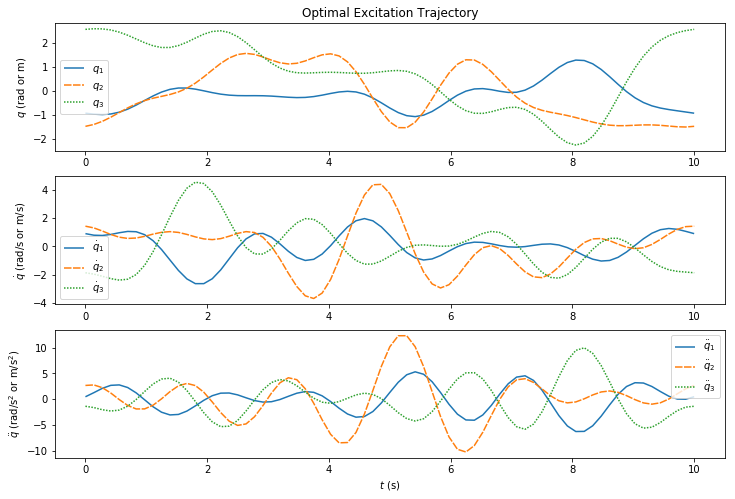

In [465]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

## Save trajectory for later use

In [466]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)


In [467]:
dof_order_bf_x_file_name = 'optimal_traj1.pkl'
dof_order_bf_x_dir = optimal_trajectory_folder + dof_order_bf_x_file_name

#if not os.path.exists(dof_order_bf_x_dir):
with open(dof_order_bf_x_dir, 'wr') as f:
    pickle.dump(dyn.H_b, f)

---
# Data processing

In [468]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [469]:
trajectory_data_file = trajectory_folder + 'test.csv'
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(trajectory_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [470]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


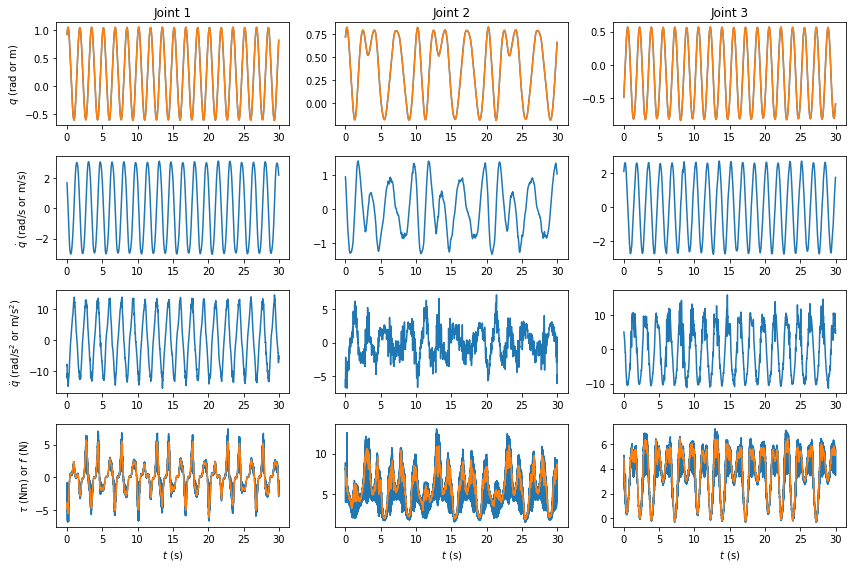

In [471]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [472]:
traj_optimizer.x_result

array([-0.18618603, -0.16208654, -0.25339989,  0.35589165, -0.0037242 ,
        0.39283052, -0.66981061, -0.01843702,  0.68936457,  0.52701204,
        0.4301865 , -0.44590276, -0.28425432, -0.14234935,  0.5107208 ,
        0.13494402, -0.07017357, -0.51948258,  0.98233521, -0.6649905 ,
        0.5128842 ,  0.83284999, -0.92006102,  0.96331684, -0.74318236,
        0.77809421,  0.72541677,  0.95831527,  0.38860971, -0.62920982,
       -0.84253675, -0.30327678,  0.71187763, -0.45218778, -0.94926869,
       -0.48619024, -0.9156519 ,  0.35373558,  0.58290284])

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [473]:
base_param_num = dyn.base_num
H_b_func = dyn.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [474]:
print(W_b.shape, tau_s.shape)

((17970, 22), (17970,))


In [475]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/yan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [476]:
sympy.Matrix.hstack(sympy.Matrix(dyn.base_param), sympy.Matrix(xb_ols))

⎡             1.0⋅l3x                 0.440771406677608  ⎤
⎢                                                        ⎥
⎢             1.0⋅l3y                 0.085330137920373  ⎥
⎢                                                        ⎥
⎢             1.0⋅L3xz               -0.00018654264223835⎥
⎢                                                        ⎥
⎢             1.0⋅L3xy               -0.0199525891520431 ⎥
⎢                                                        ⎥
⎢             1.0⋅L3yz               0.00204036890427186 ⎥
⎢                                                        ⎥
⎢             1.0⋅l2y                -0.0155717967789055 ⎥
⎢                                                        ⎥
⎢        1.0⋅l2x + 0.279⋅m₃           0.834532507979854  ⎥
⎢                                                        ⎥
⎢             1.0⋅L2xy               0.000394462231381188⎥
⎢                                                        ⎥
⎢       -1.0⋅L3xx + 1.0⋅L3yy          0.104681253989045 

## Compare measured torque and predicted torque

### Generate predicted torque

In [477]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]

### Evaluate regression

In [478]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.002262073314996384
standard deviation of xb using OLS:
[3.66809385e-04 2.75439254e-04 8.15395201e-05 7.65938579e-05
 8.69940910e-05 1.88902449e-03 8.12959862e-04 1.82505761e-04
 1.80041598e-04 1.35510821e-04 1.39008989e-04 2.52833991e-04
 4.67313407e-04 8.51490266e-04 1.68710324e-03 1.65609618e-04
 4.86585746e-04 1.65888512e-04 3.19523044e-03 1.83745528e-02
 1.38291938e-03 1.35729713e-03]
percentage of standard deviation of xb using OLS: 
[8.32198685e-04 3.22792463e-03 4.37109280e-01 3.83879292e-03
 4.26364521e-02 1.21310631e-01 9.74150023e-04 4.62669798e-01
 1.71990296e-03 1.91666985e-01 1.04406145e-03 2.80367103e-01
 1.75725001e-03 4.12743801e-02 1.09419582e-01 1.37422896e-02
 2.71734792e-03 3.33049016e-03 2.82337849e-02 4.80176442e-02
 6.59351363e-02 4.80911612e+00]


### Plot measured torque and predicted torque

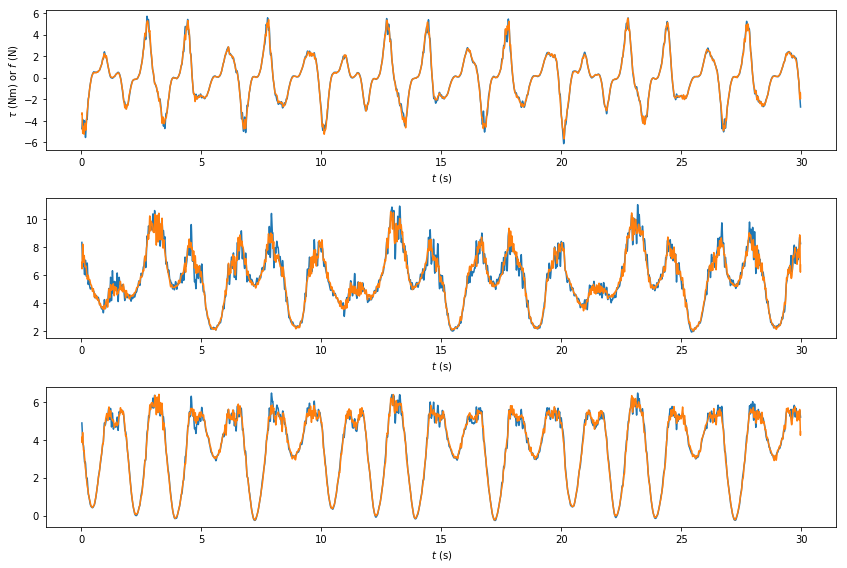

In [479]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

## Convex optimization

In [480]:
# #from identification import SDPOpt
# import cvxpy as cp

# # sdp_opt = SDPOpt(W_b, tau_s, None)
# # sdp_opt.solve()
# m, n = W_b.shape
# sdp_x = cp.Variable(n)
# sdp_obj = cp.Minimize(cp.sum_squares(W_b*sdp_x - tau_s))
# sdp_constraints = []
# sdp_prob = cp.Problem(sdp_obj, sdp_constraints)

# result = sdp_prob.solve(solver=cp.OSQP)

# print(sdp_x.value)

In [481]:
# xb_ols

### Generate regressor matrix for barycentric parameters

In [482]:
from identification import SDPOpt

bary_param_num = len(robot_def.bary_params)
H_func = dyn.H_func
W, tau_s = gen_regressor(bary_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [483]:
len(robot_def.std_params)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [484]:
# constraint order: (min_m, max_m, min_x, max_x, min_y, max_y, min_z, max_z)
# sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
#                   (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
#                   (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05),
#                   (0.5, 5, -0.1, 0.1, 0, 0.1, -0.1, 0.1),
#                   (0.1, 1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1),]
sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
                  (0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.05, 0.05),
                  (0.5, 10, 0, 0.3, 0, 0.1, -0.05, 0.05)]

sdp_constraints = [(0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 2, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01)]

In [485]:
sdp_opt_std = SDPOpt(W, tau_s, robot_def, sdp_constraints)
sdp_opt_std.solve()

Regressor shape: (17970, 37)
Regressand shape: (17970,)
Creating variables...
Creating optimization objective...
Creating constraints...
Ia3 param37
Solving problem...
[ 4.86668735e-06  0.00000000e+00  0.00000000e+00  4.86668735e-06
  0.00000000e+00 -1.99820268e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.05252314e+00  7.16976662e-05  1.20573006e-03
  1.70474083e-03  1.32484268e-01  3.33160168e-04  1.25678845e-01
  3.99832224e-01  1.40764670e-03 -1.25506761e-02  2.99832317e+00
  6.65776579e-03  5.98390439e-03  9.36465193e-03  4.93325106e-02
 -2.06457271e-02 -7.79499038e-04  1.52869390e-01  2.58845276e-03
  1.24642637e-01  4.52879236e-01  7.94301148e-02  9.70585744e-04
  1.69172368e+00  1.32605688e-02  6.14909940e-03 -1.82017242e-03
  7.52950536e-04]


In [486]:
len(sdp_opt_std._constraints)

## Compare measured torque and predicted torque

### Generate predicted torque

In [487]:
tau_sdp_p = np.zeros(tau_f.shape)
tau_sdp_ps = W.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_sdp_p[:, i] = tau_sdp_ps[i::dof]

### Plot measured torque and predicted torque

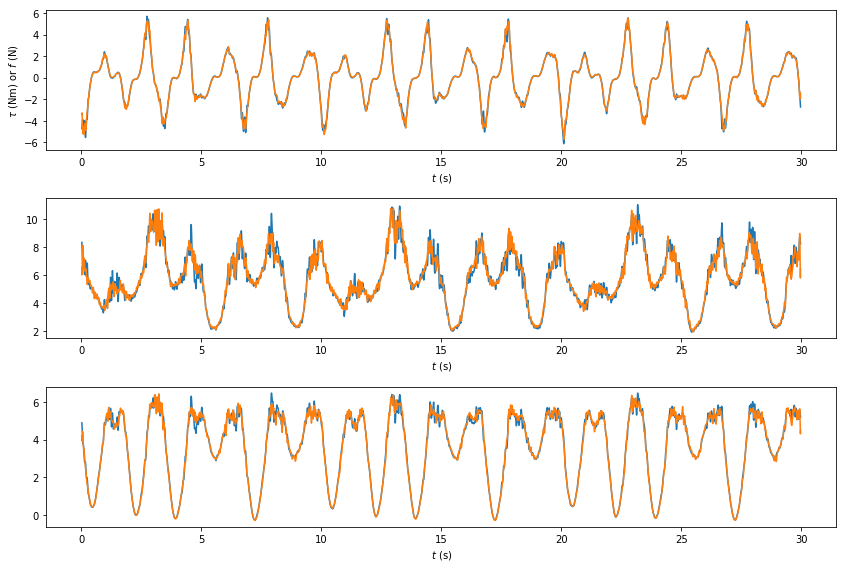

In [488]:
plot_meas_pred_tau(t_cut, tau_f, tau_sdp_p)

In [489]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.bary_params), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx   4.8666873495244e-6  ⎤
⎢                           ⎥
⎢L1xy           0.0         ⎥
⎢                           ⎥
⎢L1xz           0.0         ⎥
⎢                           ⎥
⎢L1yy   4.8666873495244e-6  ⎥
⎢                           ⎥
⎢L1yz           0.0         ⎥
⎢                           ⎥
⎢L1zz  -1.99820268246209e-6 ⎥
⎢                           ⎥
⎢l1x            0.0         ⎥
⎢                           ⎥
⎢l1y            0.0         ⎥
⎢                           ⎥
⎢l1z            0.0         ⎥
⎢                           ⎥
⎢ m₁     1.05252313749249   ⎥
⎢                           ⎥
⎢L2xx   7.16976662144303e-5 ⎥
⎢                           ⎥
⎢L2xy   0.00120573005759099 ⎥
⎢                           ⎥
⎢L2xz   0.00170474082601301 ⎥
⎢                           ⎥
⎢L2yy    0.132484267889361  ⎥
⎢                           ⎥
⎢L2yz  0.000333160167567865 ⎥
⎢                           ⎥
⎢L2zz    0.125678844931598  ⎥
⎢                           ⎥
⎢l2x     0.399832224292525  ⎥
⎢         

In [347]:
from identification import barycentric2standard_params

In [348]:
sdp_opt_std.x_result

In [349]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_def)

In [350]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.std_params), sympy.Matrix(x_std))